In [2]:
from google.colab import drive
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Yêu cầu quyền truy cập vào Google Drive
drive.mount('/content/drive', force_remount = True)

# Đường dẫn thư mục project
project_dir = '/content/drive/My Drive/Project II/'

# Kiểm tra xem project_dir có tồn tại không trước khi thay đổi thư mục làm việc
if os.path.exists(project_dir):
    os.chdir(project_dir)
    print("Nội dung trong thư mục:")
    print(os.listdir())  # Liệt kê nội dung thư mục
else:
    print(f"Thư mục không tồn tại: {project_dir}")

Mounted at /content/drive
Nội dung trong thư mục:
['preprocess', 'data', 'models', 'notebooks']


# **1. Khai báo thư viện**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.modules.loss import _Loss


import scipy.sparse as sp
import random
from scipy.special import expit
from tqdm import tqdm
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === MF-BPR ===
model_dir = '/content/drive/My Drive/Project II/models/ckpt/mf_leave_one_last.pth'

# **2. Load và chuẩn bị dữ liệu**

In [6]:
# Load dữ liệu
data_dir = project_dir + "data/"
dataset = pd.read_csv(data_dir + "recommendations_processed.csv").copy()  # Thêm .copy() để tạo bản sao rõ ràng

# Explicitly convert 'date' column to datetime objects
dataset['date'] = pd.to_datetime(dataset['date'])

# Loại trừ duplicate
dataset = dataset.sort_values("date")  # Sort theo thời gian
dataset = dataset.drop_duplicates(subset=['user_id', 'app_id'], keep='last')

# Mapping user_id, game_id sang user_index, game_index
all_user_ids = dataset['user_id'].unique()
all_game_ids = dataset['app_id'].unique()

user_id_mapping = {user_id: idx for idx, user_id in enumerate(sorted(all_user_ids))}
game_id_mapping = {item_id: idx for idx, item_id in enumerate(sorted(all_game_ids))}

# Cập nhật lại user_id, app_id sử dụng .loc
dataset.loc[:, 'user_id'] = dataset['user_id'].map(user_id_mapping)
dataset.loc[:, 'app_id'] = dataset['app_id'].map(game_id_mapping)

## **2.1. Chia dataset theo chiến lược Leave One Last**

In [7]:
def split_data_leave_one_last(df):
    df = df.copy().reset_index(names='original_index')
    test_indices = []

    for _, group in df.groupby("user_id"):
        group_sorted = group.sort_values("date")
        is_rec = group_sorted["is_recommended"].values
        idx = group_sorted.index.values
        for i in range(len(is_rec) - 1, -1, -1):
            if is_rec[i] == 1:
                test_indices.extend(idx[i:])
                break

    test_set = df.loc[test_indices].reset_index(drop=True)
    train_set = df.drop(index=test_indices).reset_index(drop=True)
    test_set = test_set.drop(columns=["original_index"])
    train_set = train_set.drop(columns=["original_index"])
    return train_set, test_set

train_df, test_df = split_data_leave_one_last(dataset)
train_df, valid_df = split_data_leave_one_last(train_df)

print(f"train_df: {train_df.shape}")
print(f"valid_df: {valid_df.shape}")
print(f"test_df: {test_df.shape}")

train_df: (2409713, 8)
valid_df: (64265, 8)
test_df: (61055, 8)


## **2.2. Thống kê dataset đơn giản**

In [8]:
# Số lượng users, games
num_users = len(all_user_ids)
num_games = len(all_game_ids)
num_nodes = num_users + num_games

print(f"Số lượng users: {num_users}")
print(f"Số lượng games: {num_games}")
print(f"Số lượng nodes: {num_nodes}")

# Print cold-start statistics
train_users = set(train_df['user_id'].unique())
train_items = set(train_df['app_id'].unique())

valid_users = set(valid_df['user_id'].unique())
valid_items = set(valid_df['app_id'].unique())

test_users = set(test_df['user_id'].unique())
test_items = set(test_df['app_id'].unique())

valid_cold_start_users = valid_users - train_users
valid_cold_start_items = valid_items - train_items
test_cold_start_users = test_users - train_users
test_cold_start_items = test_items - train_items

print("\n=== Cold-start analysis in valid ===")
print(f"Total users in valid: {len(valid_users)}")
print(f"--> Cold-start users in valid: {len(valid_cold_start_users)}")
print(f"Total items in valid: {len(valid_items)}")
print(f"--> Cold-start games in valid: {len(valid_cold_start_items)}")

print("\n=== Cold-start analysis in test ===")
print(f"Total users in test: {len(test_users)}")
print(f"--> Cold-start users in test: {len(test_cold_start_users)}")
print(f"Total items in test: {len(test_items)}")
print(f"--> Cold-start games in test: {len(test_cold_start_items)}")

Số lượng users: 47274
Số lượng games: 4632
Số lượng nodes: 51906

=== Cold-start analysis in valid ===
Total users in valid: 47274
--> Cold-start users in valid: 0
Total items in valid: 4128
--> Cold-start games in valid: 1

=== Cold-start analysis in test ===
Total users in test: 47274
--> Cold-start users in test: 0
Total items in test: 3903
--> Cold-start games in test: 1


# **3. Định nghĩa các hàm tiện ích**

## **3.1. Hàm xây dựng ma trận tương tác user-item**

In [9]:
def create_interact_matrix(dataset: pd.DataFrame, num_users: int, num_items: int) -> torch.BoolTensor:
    # Chỉ lấy các tương tác positive trên toàn bộ dataset
    pos_df = dataset[dataset['is_recommended'] == 1]
    rows = pos_df['user_id'].to_numpy()
    cols = pos_df['app_id'].to_numpy()
    data = np.ones_like(rows, dtype=np.bool_)
    mat = sp.coo_matrix((data, (rows, cols)), shape=(num_users, num_items))
    return torch.from_numpy(mat.toarray())  # dtype=bool mặc định

full_matrix = create_interact_matrix(dataset, num_users, num_games)
train_matrix = create_interact_matrix(train_df, num_users, num_games)
valid_matrix = create_interact_matrix(valid_df, num_users, num_games)

## **3.2. Các lớp bao dữ liệu**

In [10]:
class Data:
    def __init__(self, pos_users, pos_items, all_neg_items, user_to_idx):
        self.pos_users = pos_users
        self.pos_items = pos_items
        self.all_neg_items = all_neg_items
        self.user_to_idx = user_to_idx

class LeaveOneData:
  def __init__(self, labels, train_interactions, user_ids, eval_mask, game_list):
    self.labels = labels
    self.train_interactions = train_interactions
    self.user_ids = user_ids
    self.eval_mask = eval_mask
    self.game_list = game_list

## **3.3. Hàm định nghĩa các Ranking Metrics**

In [11]:
def precision_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return hits.sum(dim=1) / k

def recall_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    relevant = labels.sum(dim=1).clamp(min=1e-8)  # avoid divide by zero
    return hits.sum(dim=1) / relevant

def ndcg_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    device = scores.device
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)

    weights = torch.log2(torch.arange(2, k + 2, device=device).float())
    dcg = (hits / weights).sum(dim=1)

    ideal_len = labels.sum(dim=1).clamp(max=k).long()
    idcg = torch.stack([
        (1.0 / weights[:L]).sum() if L > 0 else torch.tensor(0.0, device=device)
        for L in ideal_len
    ])
    return dcg / idcg.clamp(min=1e-8)

def hitrate_at_k(scores: torch.Tensor, labels: torch.Tensor, k: int) -> torch.Tensor:
    topk = torch.topk(scores, k, dim=1).indices
    hits = torch.gather(labels, 1, topk)
    return (hits.sum(dim=1) > 0).float()

## **3.4. Hàm mất mát BPR**

In [12]:
class BPRLoss(_Loss):
    def __init__(self, lambda_reg: float = 1e-3):
        super().__init__()
        self.lambda_reg = lambda_reg

    def forward(self,
                pos_score: torch.Tensor,
                neg_score: torch.Tensor,
                parameters: torch.Tensor = None) -> torch.Tensor:
        if pos_score.dim() == 1:
            pos_score = pos_score.unsqueeze(1)  # [batch_size, 1]

        log_prob = F.logsigmoid(pos_score - neg_score).mean()

        regularization = 0
        if self.lambda_reg != 0 and parameters is not None:
            regularization = self.lambda_reg * parameters.norm(p=2).pow(2)
            regularization = regularization / pos_score.size(0)

        return -log_prob + regularization

# **4. Định nghĩa mô hình MF-BPR**

In [13]:
class MF_BPR(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim):
        super(MF_BPR, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        # User embedding, Item embedding
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        self.reset_parameters()

    def reset_parameters(self):
        # nn.init.xavier_normal_(self.user_embedding.weight)
        # nn.init.xavier_normal_(self.item_embedding.weight)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)

    def forward(self, user_ids: torch.Tensor, item_ids: torch.Tensor) -> torch.Tensor:
        # Get embeddings
        user_emb = self.user_embedding(user_ids)  # [batch_size, embedding_dim]
        item_emb = self.item_embedding(item_ids)  # [batch_size, embedding_dim]

        # Compute interaction
        scores = (user_emb * item_emb).sum(dim=1)  # [batch_size]
        return scores

    def compute_bpr_loss(self,
                         pos_scores: torch.Tensor,
                         neg_scores: torch.Tensor,
                         lambda_reg: float = 1e-3) -> torch.Tensor:
        loss_fn = BPRLoss(lambda_reg=lambda_reg)

        # Collect all learnable parameters
        all_params = []
        for param in self.parameters():
            if param.requires_grad:
                all_params.append(param.view(-1))

        concatenated_params = torch.cat(all_params) if all_params else None
        return loss_fn(pos_scores, neg_scores, concatenated_params)

# **5. Huấn luyện mô hình**

## **5.1. Định nghĩa hàm train**

In [17]:
def train(model, train_data, train_loader, scheduler, optimizer, device, lambda_reg=1e-3, criterion='bpr', num_neg=3):
    model.train()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    pos_users = train_data.pos_users.to(device)
    pos_items = train_data.pos_items.to(device)
    all_neg_items = train_data.all_neg_items.to(device)
    user_to_train_idx = train_data.user_to_idx

    for batch_index in tqdm(train_loader, desc="Training", leave=False):
        # === Positive Samples ===
        batch_pos_users = pos_users[batch_index]
        batch_pos_items = pos_items[batch_index]
        batch_size = batch_pos_users.size(0)

        # === Negative Sampling ===
        batch_train_indices = torch.tensor(
            [user_to_train_idx[u.item()] for u in batch_pos_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_train_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_pos_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = neg_items.reshape(-1)  # [batch_size * num_neg]

        # === Compute scores ===
        pos_scores = model(batch_pos_users, batch_pos_items)  # [batch_size]  # Use batch_pos_items instead of batch_neg_items
        neg_scores = model(batch_neg_users, batch_neg_items)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        optimizer.zero_grad()
        if criterion == 'bpr':
            loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                        neg_scores=neg_scores,
                                        lambda_reg=lambda_reg)
        else:
            raise ValueError(f"Unknown Loss Type: {criterion}")

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    scheduler.step()
    train_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return train_loss

## **5.2. Định nghĩa hàm validate**

In [18]:
@torch.no_grad()
def validate(model, valid_data, valid_loader, device, criterion='bpr', num_neg=3):
    model.eval()
    total_loss = 0.0
    total_examples = 0

    num_users = model.num_users
    num_items = model.num_items

    pos_users = valid_data.pos_users.to(device)
    pos_items = valid_data.pos_items.to(device)
    all_neg_items = valid_data.all_neg_items.to(device)
    user_to_valid_idx = valid_data.user_to_idx

    for batch_index in tqdm(valid_loader, desc="Validating", leave=False):
        # === Positive Samples ===
        batch_pos_users = pos_users[batch_index]
        batch_pos_items = pos_items[batch_index]
        batch_size = batch_pos_users.size(0)

        # === Negative Sampling ===
        batch_valid_indices = torch.tensor(
            [user_to_valid_idx[u.item()] for u in batch_pos_users],
            dtype=torch.long, device=device
        )
        user_neg_items = all_neg_items[batch_valid_indices]  # [batch_size, num_items]
        neg_items = torch.multinomial(user_neg_items.float(), num_samples=num_neg, replacement=True)  # [batch_size, num_neg]

        # Expand users to match negative samples
        batch_neg_users = batch_pos_users.unsqueeze(1).expand(-1, num_neg).reshape(-1)  # [batch_size * num_neg]
        batch_neg_items = neg_items.reshape(-1)  # [batch_size * num_neg]

        # === Compute scores ===
        pos_scores = model(batch_pos_users, batch_pos_items)  # [batch_size]  # Use batch_pos_items instead of batch_neg_items
        neg_scores = model(batch_neg_users, batch_neg_items)  # [batch_size * num_neg]
        neg_scores = neg_scores.view(batch_size, num_neg)  # [batch_size, num_neg]

        # === Compute loss ===
        loss = model.compute_bpr_loss(pos_scores=pos_scores,
                                    neg_scores=neg_scores,
                                    lambda_reg=0.0)

        total_loss += loss.item() * batch_size
        total_examples += batch_size

    valid_loss = total_loss / total_examples if total_examples > 0 else 0.0
    return valid_loss

## **5.3. Định nghĩa hàm evaluate**

In [19]:
@torch.no_grad()
def evaluate_ranking_leave_one_last(model, test_data, device, k=10, batch_size=4096):
    """
    Evaluate model using leave-one-last strategy.
    For each user:
    - One recent positive item
    - 100 random negative items
    """
    model.eval()
    num_users = model.num_users
    num_games = model.num_items

    # Get embeddings
    user_emb = model.user_embedding.weight
    item_emb = model.item_embedding.weight

    # Get test data
    test_labels = test_data.labels
    train_interactions = test_data.train_interactions
    user_ids = test_data.user_ids
    eval_mask = test_data.eval_mask
    game_list = test_data.game_list

    # Ensure item embeddings match the game list
    item_emb = item_emb[:len(game_list)]

    # Metrics storage
    all_ndcg = []
    all_hit = []

    num_test = user_ids.size(0)

    # Process in batches
    for start in tqdm(range(0, num_test, batch_size), desc="Evaluating", leave=False):
        end = min(start + batch_size, num_test)
        batch_idx = slice(start, end)
        batch_user_ids = user_ids[batch_idx]

        # Get user embeddings
        batch_u_emb = user_emb[batch_user_ids]

        # Compute scores for all items
        batch_scores = batch_u_emb @ item_emb.T

        # Mask out items not in evaluation set
        batch_scores = batch_scores.masked_fill(~eval_mask[batch_idx], -float('inf'))
        batch_labels = test_labels[batch_idx]

        # Skip users with no positive labels
        valid_users = batch_labels.sum(dim=1) > 0
        if not valid_users.any():
            continue

        batch_scores = batch_scores[valid_users]
        batch_labels = batch_labels[valid_users]

        # Compute metrics
        ndcg = ndcg_at_k(batch_scores, batch_labels, k)
        hitrate = hitrate_at_k(batch_scores, batch_labels, k)

        all_ndcg.append(ndcg)
        all_hit.append(hitrate)

    # Compute average metrics
    avg_ndcg = torch.cat(all_ndcg).mean().item() if all_ndcg else 0.0
    avg_hit = torch.cat(all_hit).mean().item() if all_hit else 0.0

    return {
        f"NDCG@{k}": avg_ndcg,
        f"HitRate@{k}": avg_hit
    }

## **5.4. Train Loss, Valid Loss, NDCG@10, HitRate@10**

### **5.4.1. Chuẩn bị dữ liệu trước khi huấn luyện**

In [20]:
# Create mapping from global user indices to training user indices
train_users_tensor = torch.tensor(list(train_users), dtype=torch.long)
train_num_users = train_users_tensor.size(0)
user_to_train_idx = {u.item(): i for i, u in enumerate(train_users_tensor)}

# Extract positive interactions from train_df
train_pos_df = train_df[train_df['is_recommended'] == 1]
train_pos_users = torch.tensor(train_pos_df['user_id'].values, dtype=torch.long)
train_pos_items = torch.tensor(train_pos_df['app_id'].values, dtype=torch.long)

# Pre-compute all possible negative items for each user in train dataset
train_all_neg_items = torch.zeros((train_num_users, num_games), dtype=torch.bool)
for i, u in enumerate(train_users_tensor):
    train_all_neg_items[i] = ~full_matrix[u]

# Create Data object
train_data = Data(
    pos_users=train_pos_users,
    pos_items=train_pos_items,
    all_neg_items=train_all_neg_items,
    user_to_idx=user_to_train_idx
)

In [21]:
valid_users_in_matrix = torch.tensor(list(valid_users), dtype=torch.long)
valid_num_users = valid_users_in_matrix.size(0)
user_to_valid_idx = {u.item(): i for i, u in enumerate(valid_users_in_matrix)}

# Extract positive interactions from valid_df
valid_pos_df = valid_df[valid_df['is_recommended'] == 1]
valid_pos_users = torch.tensor(valid_pos_df['user_id'].values, dtype=torch.long)
valid_pos_items = torch.tensor(valid_pos_df['app_id'].values, dtype=torch.long)

# Pre-compute negative items for validation dataset
valid_all_neg_items = torch.zeros((valid_num_users, num_games), dtype=torch.bool)
# Iterate through the mapped user IDs present in the validation matrix
for i, mapped_user_id in enumerate(valid_users_in_matrix):
    # Use the mapped_user_id to index the full_matrix (or valid_matrix if preferred, but full_matrix is consistent with train)
    valid_all_neg_items[i] = ~full_matrix[mapped_user_id]

# Create Data object
valid_data = Data(
    pos_users=valid_pos_users,
    pos_items=valid_pos_items,
    all_neg_items=valid_all_neg_items,
    user_to_idx=user_to_valid_idx
)

In [22]:
# Create data loader
train_loader = DataLoader(
    dataset = range(len(train_data.pos_users)),
    batch_size = 8192,
    shuffle = True,
    num_workers = 2,
    pin_memory=True
)

# Create data loader
valid_loader = DataLoader(
    dataset=range(len(valid_data.pos_users)),
    batch_size=8192,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

In [23]:
def create_leave_one_last_data(train_df, test_df, device, num_neg_samples=100):
    """
    Create test data for leave-one-last evaluation strategy.
    For each user:
    - One recent positive item from test set
    - 100 random negative items from training set
    """
    # Get unique games from training set
    game_list = sorted(train_df["app_id"].unique())
    game2idx = {game_id: idx for idx, game_id in enumerate(game_list)}
    num_games = len(game_list)

    # Get test users and their positive items
    test_users = test_df["user_id"].unique()
    user2idx = {user_id: idx for idx, user_id in enumerate(test_users)}
    num_test_users = len(test_users)

    # Create user-item interaction matrix for training
    train_interactions = torch.zeros((num_test_users, num_games), dtype=torch.bool, device=device)
    for user_id, game_id in zip(train_df["user_id"], train_df["app_id"]):
        if user_id in user2idx and game_id in game2idx:
            u_idx = user2idx[user_id]
            g_idx = game2idx[game_id]
            train_interactions[u_idx, g_idx] = True

    # Create test labels (one positive item per user)
    test_labels = torch.zeros((num_test_users, num_games), dtype=torch.float, device=device)
    for user_id, game_id in zip(test_df["user_id"], test_df["app_id"]):
        if user_id in user2idx and game_id in game2idx:
            u_idx = user2idx[user_id]
            g_idx = game2idx[game_id]
            test_labels[u_idx, g_idx] = 1.0

    # Create mask for items to evaluate (positive + 100 negative)
    eval_mask = torch.zeros((num_test_users, num_games), dtype=torch.bool, device=device)

    for i, user_id in enumerate(test_users):
        u_idx = user2idx[user_id]

        # Get positive item from test set
        pos_items = torch.where(test_labels[u_idx] == 1)[0]
        if len(pos_items) > 0:
            eval_mask[u_idx, pos_items[0]] = True

        # Get negative items from training set
        neg_items = torch.where(~train_interactions[u_idx])[0]
        if len(neg_items) >= num_neg_samples:
            # Randomly select num_neg_samples negative items
            selected_neg = neg_items[torch.randperm(len(neg_items))[:num_neg_samples]]
            eval_mask[u_idx, selected_neg] = True

    # Create user IDs tensor
    user_ids_tensor = torch.tensor(test_users, dtype=torch.long, device=device)

    return LeaveOneData(
        labels=test_labels,
        train_interactions=train_interactions,
        user_ids=user_ids_tensor,
        eval_mask=eval_mask,
        game_list=game_list
    )

In [24]:
evaluate_data = create_leave_one_last_data(train_df, valid_df, device)

### **5.4.2. Khởi tạo mô hình và huấn luyện**

In [25]:
model = MF_BPR(num_users, num_games, embedding_dim=64).to(device)

print("Tham số của mô hình:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"param_name: {name}, param_size: {param.size()}, requires_grad: {param.requires_grad}")

Tham số của mô hình:
param_name: user_embedding.weight, param_size: torch.Size([47274, 64]), requires_grad: True
param_name: item_embedding.weight, param_size: torch.Size([4632, 64]), requires_grad: True


In [26]:
optimizer = optim.Adam(model.parameters(), lr = 0.01)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 0.0005)
num_epochs = 50

train_losses, valid_losses, ndcgs_10, hitrates_10 = [], [], [], []
best_ndcg_10 = 0.0
best_hitrate_10 = 0.0

for epoch in range(1, num_epochs + 1):
    train_loss = train(
      model = model,
      train_data = train_data,
      train_loader = train_loader,
      optimizer = optimizer,
      scheduler = scheduler,
      device = device,
      lambda_reg = 1e-3,
      criterion = 'bpr',
      num_neg = 3
    )

    valid_loss = validate(
      model = model,
      valid_data = valid_data,
      valid_loader = valid_loader,
      device = device,
      criterion = 'bpr',
      num_neg = 3
    )

    evaluation_results = evaluate_ranking_leave_one_last(model = model,
                                                         test_data = evaluate_data,
                                                         device = device)

    ndcg_10 = evaluation_results["NDCG@10"]
    hitrate_10 = evaluation_results["HitRate@10"]

    print(f"Epoch: {epoch:02d} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | NDCG@10: {ndcg_10:.4f} | HitRate@10: {hitrate_10:.4f}")

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    ndcgs_10.append(ndcg_10)
    hitrates_10.append(hitrate_10)

    if ndcg_10 > best_ndcg_10 and hitrate_10 > best_hitrate_10:
        best_ndcg_10 = ndcg_10
        best_hitrate_10 = hitrate_10
        if os.path.exists(model_dir):
            os.remove(model_dir)
        torch.save(model.state_dict(), model_dir)
        print("---> Best checkpoint is saved!")

Epoch: 01 | Train Loss: 0.4138 | Valid Loss: 0.4303 | NDCG@10: 0.2404 | HitRate@10: 0.4801
---> Best checkpoint is saved!


Epoch: 02 | Train Loss: 0.2345 | Valid Loss: 0.3667 | NDCG@10: 0.2661 | HitRate@10: 0.5215
---> Best checkpoint is saved!


Epoch: 03 | Train Loss: 0.1947 | Valid Loss: 0.3442 | NDCG@10: 0.2768 | HitRate@10: 0.5390
---> Best checkpoint is saved!


Epoch: 04 | Train Loss: 0.1744 | Valid Loss: 0.3406 | NDCG@10: 0.2830 | HitRate@10: 0.5476
---> Best checkpoint is saved!


Epoch: 05 | Train Loss: 0.1628 | Valid Loss: 0.3413 | NDCG@10: 0.2838 | HitRate@10: 0.5509
---> Best checkpoint is saved!


Epoch: 06 | Train Loss: 0.1564 | Valid Loss: 0.3440 | NDCG@10: 0.2851 | HitRate@10: 0.5509
---> Best checkpoint is saved!


Epoch: 07 | Train Loss: 0.1520 | Valid Loss: 0.3482 | NDCG@10: 0.2859 | HitRate@10: 0.5503


Epoch: 08 | Train Loss: 0.1495 | Valid Loss: 0.3521 | NDCG@10: 0.2841 | HitRate@10: 0.5485


Epoch: 09 | Train Loss: 0.1475 | Valid Loss: 0.3536 | NDCG@10: 0.2864 | HitRate@10: 0.5506


Epoch: 10 | Train Loss: 0.1455 | Valid Loss: 0.3578 | NDCG@10: 0.2853 | HitRate@10: 0.5494


Epoch: 11 | Train Loss: 0.1441 | Valid Loss: 0.3536 | NDCG@10: 0.2877 | HitRate@10: 0.5521
---> Best checkpoint is saved!


Epoch: 12 | Train Loss: 0.1419 | Valid Loss: 0.3550 | NDCG@10: 0.2879 | HitRate@10: 0.5519


Epoch: 13 | Train Loss: 0.1406 | Valid Loss: 0.3551 | NDCG@10: 0.2881 | HitRate@10: 0.5520


Epoch: 14 | Train Loss: 0.1393 | Valid Loss: 0.3548 | NDCG@10: 0.2877 | HitRate@10: 0.5507


Epoch: 15 | Train Loss: 0.1379 | Valid Loss: 0.3548 | NDCG@10: 0.2895 | HitRate@10: 0.5509


Epoch: 16 | Train Loss: 0.1361 | Valid Loss: 0.3530 | NDCG@10: 0.2883 | HitRate@10: 0.5511


Epoch: 17 | Train Loss: 0.1346 | Valid Loss: 0.3501 | NDCG@10: 0.2892 | HitRate@10: 0.5532
---> Best checkpoint is saved!


Epoch: 18 | Train Loss: 0.1332 | Valid Loss: 0.3500 | NDCG@10: 0.2887 | HitRate@10: 0.5531


Epoch: 19 | Train Loss: 0.1316 | Valid Loss: 0.3507 | NDCG@10: 0.2895 | HitRate@10: 0.5539
---> Best checkpoint is saved!


Epoch: 20 | Train Loss: 0.1301 | Valid Loss: 0.3437 | NDCG@10: 0.2916 | HitRate@10: 0.5562
---> Best checkpoint is saved!


Epoch: 21 | Train Loss: 0.1284 | Valid Loss: 0.3485 | NDCG@10: 0.2920 | HitRate@10: 0.5552


Epoch: 22 | Train Loss: 0.1271 | Valid Loss: 0.3474 | NDCG@10: 0.2934 | HitRate@10: 0.5569
---> Best checkpoint is saved!


Epoch: 23 | Train Loss: 0.1255 | Valid Loss: 0.3468 | NDCG@10: 0.2948 | HitRate@10: 0.5591
---> Best checkpoint is saved!


Epoch: 24 | Train Loss: 0.1242 | Valid Loss: 0.3439 | NDCG@10: 0.2939 | HitRate@10: 0.5589


Epoch: 25 | Train Loss: 0.1227 | Valid Loss: 0.3411 | NDCG@10: 0.2948 | HitRate@10: 0.5585


Epoch: 26 | Train Loss: 0.1214 | Valid Loss: 0.3383 | NDCG@10: 0.2952 | HitRate@10: 0.5610
---> Best checkpoint is saved!


Epoch: 27 | Train Loss: 0.1202 | Valid Loss: 0.3433 | NDCG@10: 0.2955 | HitRate@10: 0.5599


Epoch: 28 | Train Loss: 0.1187 | Valid Loss: 0.3369 | NDCG@10: 0.2967 | HitRate@10: 0.5612
---> Best checkpoint is saved!


Epoch: 29 | Train Loss: 0.1173 | Valid Loss: 0.3373 | NDCG@10: 0.2980 | HitRate@10: 0.5637
---> Best checkpoint is saved!


Epoch: 30 | Train Loss: 0.1162 | Valid Loss: 0.3386 | NDCG@10: 0.2978 | HitRate@10: 0.5636


Epoch: 31 | Train Loss: 0.1148 | Valid Loss: 0.3322 | NDCG@10: 0.2992 | HitRate@10: 0.5661
---> Best checkpoint is saved!


Epoch: 32 | Train Loss: 0.1138 | Valid Loss: 0.3341 | NDCG@10: 0.2998 | HitRate@10: 0.5663
---> Best checkpoint is saved!


Epoch: 33 | Train Loss: 0.1126 | Valid Loss: 0.3339 | NDCG@10: 0.3004 | HitRate@10: 0.5671
---> Best checkpoint is saved!


Epoch: 34 | Train Loss: 0.1114 | Valid Loss: 0.3333 | NDCG@10: 0.3013 | HitRate@10: 0.5677
---> Best checkpoint is saved!


Epoch: 35 | Train Loss: 0.1105 | Valid Loss: 0.3289 | NDCG@10: 0.3024 | HitRate@10: 0.5694
---> Best checkpoint is saved!


Epoch: 36 | Train Loss: 0.1094 | Valid Loss: 0.3298 | NDCG@10: 0.3026 | HitRate@10: 0.5698
---> Best checkpoint is saved!


Epoch: 37 | Train Loss: 0.1085 | Valid Loss: 0.3286 | NDCG@10: 0.3026 | HitRate@10: 0.5687


Epoch: 38 | Train Loss: 0.1077 | Valid Loss: 0.3273 | NDCG@10: 0.3030 | HitRate@10: 0.5705
---> Best checkpoint is saved!


Epoch: 39 | Train Loss: 0.1068 | Valid Loss: 0.3296 | NDCG@10: 0.3032 | HitRate@10: 0.5716
---> Best checkpoint is saved!


Epoch: 40 | Train Loss: 0.1061 | Valid Loss: 0.3250 | NDCG@10: 0.3040 | HitRate@10: 0.5712


Epoch: 41 | Train Loss: 0.1055 | Valid Loss: 0.3254 | NDCG@10: 0.3042 | HitRate@10: 0.5713


Epoch: 42 | Train Loss: 0.1047 | Valid Loss: 0.3231 | NDCG@10: 0.3051 | HitRate@10: 0.5720
---> Best checkpoint is saved!


Epoch: 43 | Train Loss: 0.1041 | Valid Loss: 0.3220 | NDCG@10: 0.3061 | HitRate@10: 0.5731
---> Best checkpoint is saved!


Epoch: 44 | Train Loss: 0.1036 | Valid Loss: 0.3232 | NDCG@10: 0.3059 | HitRate@10: 0.5731


Epoch: 45 | Train Loss: 0.1033 | Valid Loss: 0.3231 | NDCG@10: 0.3060 | HitRate@10: 0.5739


Epoch: 46 | Train Loss: 0.1028 | Valid Loss: 0.3205 | NDCG@10: 0.3064 | HitRate@10: 0.5736
---> Best checkpoint is saved!


Epoch: 47 | Train Loss: 0.1026 | Valid Loss: 0.3240 | NDCG@10: 0.3068 | HitRate@10: 0.5742
---> Best checkpoint is saved!


Epoch: 48 | Train Loss: 0.1023 | Valid Loss: 0.3212 | NDCG@10: 0.3070 | HitRate@10: 0.5751
---> Best checkpoint is saved!


Epoch: 49 | Train Loss: 0.1019 | Valid Loss: 0.3192 | NDCG@10: 0.3070 | HitRate@10: 0.5749


Epoch: 50 | Train Loss: 0.1018 | Valid Loss: 0.3232 | NDCG@10: 0.3069 | HitRate@10: 0.5750


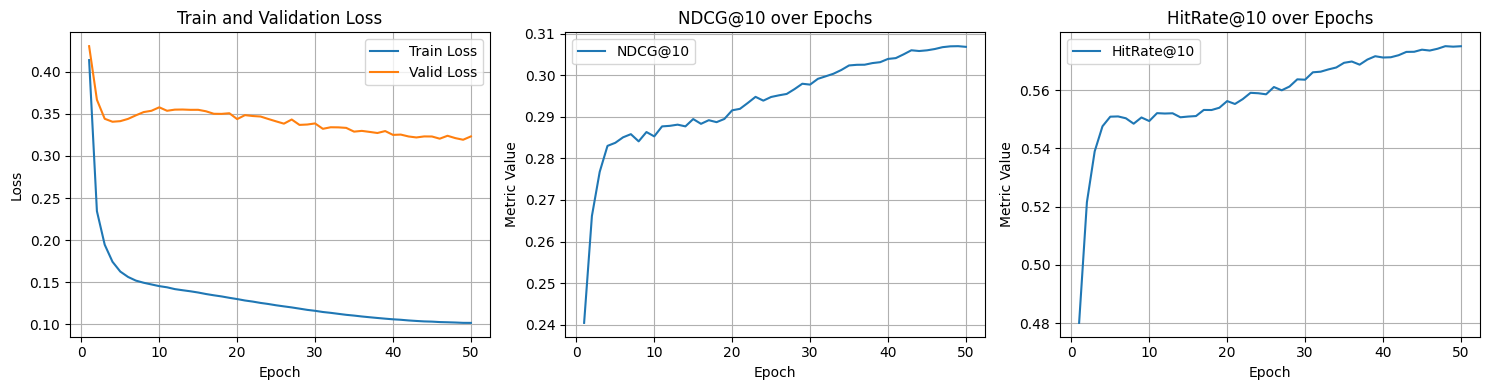

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 hàng, 3 cột

# Create a range of epoch numbers for the x-axis
epochs_range = range(1, len(train_losses) + 1)

# --- Plot 1: Training and Validation Losses ---
axes[0].plot(epochs_range, train_losses, label='Train Loss')
axes[0].plot(epochs_range, valid_losses, label='Valid Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Train and Validation Loss')
axes[0].legend()
axes[0].grid(True)
axes[0].set_ylim(0.0, 1.0)
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

# --- Plot 2: NDCG@10 over Epochs ---
axes[1].plot(epochs_range, ndcgs_10, label='NDCG@10')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Metric Value')
axes[1].set_title('NDCG@10 over Epochs')
axes[1].legend()
axes[1].grid(True)
axes[1].set_ylim(0.0, 0.1)
axes[1].set_yticks([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1])

# --- Plot 3: HitRate@10 over Epochs ---
axes[2].plot(epochs_range, hitrates_10, label='HitRate@10')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Metric Value')
axes[2].set_title('HitRate@10 over Epochs')
axes[2].legend()
axes[2].grid(True)
axes[2].set_ylim(0.0, 0.5)
axes[2].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

plt.tight_layout()
plt.show()

# **6. Đánh giá khả năng xếp hạng (ranking)**

In [28]:
model = MF_BPR(num_users, num_games, embedding_dim=64)
# Load model with proper device mapping
model.load_state_dict(torch.load(model_dir, map_location=device))
model.to(device)  # Move model to appropriate device

MF_BPR(
  (user_embedding): Embedding(47274, 64)
  (item_embedding): Embedding(4632, 64)
)

In [29]:
test_data = create_leave_one_last_data(train_df, test_df, device)

# Đánh giá dựa trên leave one last
leave_one_last_result = evaluate_ranking_leave_one_last(model, test_data, device)
print("\n--- Leave One Last Ranking Metrics ---")
for metric, value in leave_one_last_result.items():
    print(f"{metric}: {value:.4f}")


--- Leave One Last Ranking Metrics ---
NDCG@10: 0.2684
HitRate@10: 0.5097
